# Top-selling item recommendation analysis

Recommend top-selling items in the past to returning customers who have not yet purchased those items

- Identify top 12 selling items from 1st-7th day and 15th-21st day each month (2018-10 ~ 2020-08)
- Check numbers items were actually purchased by returning users from 8th-14th and 22nd-28th day each month
- Use AOP@12 and MAP@12 to evaluate the results

Best selling items EDA on Kaggle: https://www.kaggle.com/negoto/best-selling-items-catalog-like-eda-of-articles

In [1]:
import pandas as pd
import numpy as np
import collaborative_filter as cf
import matplotlib.pyplot as plt

In [2]:
%%time
transaction_raw = pd.read_csv("../data/transactions_train.csv")

Wall time: 36.3 s


In [3]:
traintest_day = ['01','07','08','14','15','21','22','28']

In [4]:
eval_month = ['2018-10','2018-11','2018-12','2019-01','2019-02','2019-03','2019-04','2019-05']

In [ ]:
eval_month = ['2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12','2020-01']

In [ ]:
eval_month = ['2020-02','2020-03','2020-04','2020-05','2020-06','2020-07','2020-08']

In [5]:
%%time

AOP_results = []
MAP_results = []
num_users = []

for i in range(len(eval_month)): #i: 0-21
    for j in [0,4]: #j:0, 4
        
        mask_train = (transaction_raw.t_dat >= eval_month[i]+'-'+traintest_day[j]) & \
                     (transaction_raw.t_dat <= eval_month[i]+'-'+traintest_day[j+1])
        X_train = transaction_raw.loc[mask_train].reset_index(drop=True)[['customer_id','article_id']]
        mask_test = (transaction_raw.t_dat >= eval_month[i]+'-'+traintest_day[j+2]) & \
                    (transaction_raw.t_dat <= eval_month[i]+'-'+traintest_day[j+3])
        X_test = transaction_raw.loc[mask_test].reset_index(drop=True)[['customer_id','article_id']]
        
        #find out top 12 selling items in training data
        top12items = list(X_train.head(100000).article_id.value_counts()[0:12].index)
        
        #save top 12 selling items for users in a dict
        top12_items = {}
        for user in X_train.customer_id:
            top12_items[user] = top12items
        
        #calculate AOP@12 for each train-test group
        AOP12_top, num_user = cf.AOP(top12_items, X_test)
        AOP_results.append(AOP12_top)
        
        #calculate MAP@12 for each train-test group
        MAP12_top, num_user = cf.MAP(top12_items, X_test)
        MAP_results.append(MAP12_top)
        
        #append number of users
        num_users.append(num_user)

100%|███████████████████████████████████| 72262/72262 [05:20<00:00, 225.72it/s]


Number of users: 13405


100%|███████████████████████████████████| 72262/72262 [05:22<00:00, 223.73it/s]


Number of users: 13405


100%|███████████████████████████████████| 76681/76681 [07:14<00:00, 176.68it/s]


Number of users: 16497


100%|███████████████████████████████████| 76681/76681 [07:50<00:00, 162.97it/s]


Number of users: 16497


100%|███████████████████████████████████| 70960/70960 [04:07<00:00, 286.78it/s]


Number of users: 12315


100%|███████████████████████████████████| 70960/70960 [04:09<00:00, 284.17it/s]


Number of users: 12315


100%|███████████████████████████████████| 75799/75799 [09:33<00:00, 132.07it/s]


Number of users: 19210


100%|███████████████████████████████████| 75799/75799 [09:34<00:00, 131.94it/s]


Number of users: 19210


100%|███████████████████████████████████| 69797/69797 [04:02<00:00, 288.35it/s]


Number of users: 12636


100%|███████████████████████████████████| 69797/69797 [04:02<00:00, 288.16it/s]


Number of users: 12636


100%|███████████████████████████████████| 87335/87335 [05:35<00:00, 260.02it/s]


Number of users: 15924


100%|███████████████████████████████████| 87335/87335 [05:45<00:00, 253.12it/s]


Number of users: 15924


100%|███████████████████████████████████| 68725/68725 [04:47<00:00, 239.37it/s]


Number of users: 12642


100%|███████████████████████████████████| 68725/68725 [04:49<00:00, 237.41it/s]


Number of users: 12642


100%|███████████████████████████████████| 66553/66553 [04:33<00:00, 243.54it/s]


Number of users: 12624


100%|███████████████████████████████████| 66553/66553 [04:31<00:00, 245.41it/s]


Number of users: 12624


100%|███████████████████████████████████| 69291/69291 [03:33<00:00, 325.22it/s]


Number of users: 11714


100%|███████████████████████████████████| 69291/69291 [03:35<00:00, 322.21it/s]


Number of users: 11714


100%|███████████████████████████████████| 73534/73534 [05:48<00:00, 210.92it/s]


Number of users: 14553


100%|███████████████████████████████████| 73534/73534 [05:39<00:00, 216.73it/s]


Number of users: 14553


100%|███████████████████████████████████| 69435/69435 [03:51<00:00, 300.33it/s]


Number of users: 12223


100%|███████████████████████████████████| 69435/69435 [03:51<00:00, 300.43it/s]


Number of users: 12223


100%|███████████████████████████████████| 69013/69013 [04:35<00:00, 250.91it/s]


Number of users: 13201


100%|███████████████████████████████████| 69013/69013 [04:35<00:00, 250.63it/s]


Number of users: 13201


100%|███████████████████████████████████| 85437/85437 [04:57<00:00, 287.29it/s]


Number of users: 15151


100%|███████████████████████████████████| 85437/85437 [04:57<00:00, 287.16it/s]


Number of users: 15151


100%|███████████████████████████████████| 75631/75631 [06:08<00:00, 205.37it/s]


Number of users: 15270


100%|███████████████████████████████████| 75631/75631 [06:11<00:00, 203.59it/s]


Number of users: 15270


100%|███████████████████████████████████| 84670/84670 [04:31<00:00, 312.37it/s]


Number of users: 14231


100%|███████████████████████████████████| 84670/84670 [04:30<00:00, 312.47it/s]


Number of users: 14231


100%|███████████████████████████████████| 79995/79995 [06:34<00:00, 202.67it/s]


Number of users: 16530


100%|███████████████████████████████████| 79995/79995 [06:31<00:00, 204.41it/s]

Number of users: 16530
Wall time: 2h 52min 42s


In [6]:
#create a timeline list for AOP and MAP
timeline = []
for month in eval_month:
    month_mid = month + '-15'
    month_late = month + '-22'
    timeline.append(month_mid)
    timeline.append(month_late)

In [7]:
#save results in a dataframe
result_df = pd.DataFrame({'timeline':timeline,
                          'AOP':AOP_results,
                          'MAP':MAP_results,
                          'num_users':num_users})

#save the dataframe in csv
#change file name for different period groups
result_df.to_csv("../data/top_sell_results1.csv")

result_df.head()

,timeline,AOP,MAP,num_users
0,2018-10-15,0.002829,0.003706,13405
1,2018-10-22,0.003278,0.003650,16497
2,2018-11-15,0.003323,0.004229,12315
3,2018-11-22,0.003535,0.003982,19210
4,2018-12-15,0.003363,0.003742,12636


In [15]:
result_df.to_csv("../data/top_sell_MAP12.csv")

In [2]:
#import results
df = pd.read_csv("../data/top_sell_MAP12.csv")

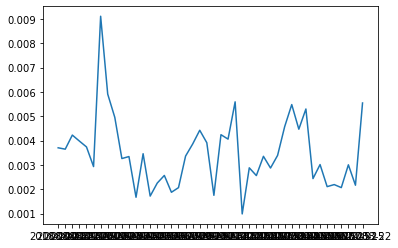

In [5]:
plt.plot(df.timeline, df.MAP)

In [3]:
#extract data between 2019-5-1 and 2019-6-1
mask = (transaction_raw.t_dat >= '2019-05-01') & (transaction_raw.t_dat <= '2019-06-01')
transaction_2019_May = transaction_raw.loc[mask].reset_index(drop=True)
transaction_2019_May

,t_dat,customer_id,article_id,price,sales_channel_id
0,2019-05-01,00019d6c20e0fbb551af18c57149af4707ec016bb0decd...,524061003,0.050831,2
1,2019-05-01,00019d6c20e0fbb551af18c57149af4707ec016bb0decd...,735404001,0.050831,2
2,2019-05-01,00019d6c20e0fbb551af18c57149af4707ec016bb0decd...,700370004,0.016932,2
3,2019-05-01,00019d6c20e0fbb551af18c57149af4707ec016bb0decd...,618800001,0.033881,2
4,2019-05-01,00019d6c20e0fbb551af18c57149af4707ec016bb0decd...,731407001,0.016932,2
...,...,...,...,...,...
1622933,2019-06-01,fffdaab7d9d79ceee4ffd2ab98bb68411438ea90e46a67...,738881002,0.016932,2
1622934,2019-06-01,fffdaab7d9d79ceee4ffd2ab98bb68411438ea90e46a67...,220094010,0.025407,2
1622935,2019-06-01,ffff4c4e8b57b633c1ddf8fbd53db16b962cf831baf9ed...,487800001,0.011847,2
1622936,2019-06-01,ffff4c4e8b57b633c1ddf8fbd53db16b962cf831baf9ed...,754013001,0.022017,2


In [8]:
len(MAP_results)

44

In [30]:
MAP12_cf = cf.MAP(recommend_items, X_test)
print("User-based collaborative filter MAP@12:", MAP12_cf)

100%|███████████████████████████████████████████████████████████████████████████| 24031/24031 [01:18<00:00, 307.11it/s]

Number of users: 4332
User-based collaborative filter MAP@12: 0.0037136724997412925


In [31]:
##Identify top 12 selling items for training data
top12items = list(X_train.head(100000).article_id.value_counts()[0:12].index)

#save top 12 selling items for users in a dict
top12_items = {}
for user in recommend_items:
    top12_items[user] = top12items

In [33]:
MAP12_top = cf.MAP(top12_items, X_test)
print("Top 12 selling products MAP@12:", MAP12_top)

100%|███████████████████████████████████████████████████████████████████████████| 24031/24031 [01:21<00:00, 295.16it/s]

Number of users: 4332
Top 12 selling products MAP@12: 0.0020729474647988057


In [38]:
# % increase in MAP@12
print("MAP@12 increases by", round(100*(MAP12_cf-MAP12_top)/MAP12_top), "%")

MAP@12 increases by 79 %
